In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from src.data_processor.phase_1.prob2.v2 import Phase1Prob2FeatureProcessor
from catboost import CatBoostClassifier

In [2]:
df = pd.read_parquet("/mnt/f/Data/MLOPS_2023/data_phase-1/phase-1/prob-2/raw_train.parquet")
test = pd.read_csv('/home/duclh3/Workspace/test_phase1_prob2/mlops_phase1_prob2_207c042d-7882-4831-b2bc-1740c5ed739e.csv')

In [3]:
processor = Phase1Prob2FeatureProcessor()
new_df = processor.fit_transform(df)

feature1
feature1
feature3
feature3
feature4
feature4
feature6
feature6
feature7
feature7
feature9
feature9
feature10
feature10
feature12
feature12
feature14
feature14
feature15
feature15
feature17
feature17
feature19
feature19
feature20
feature20


In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [5]:
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
TARGET = 'label'

In [6]:
new_df.shape, df.shape

((60000, 21), (60000, 21))

In [12]:
models = []
scores = []
oofs = np.zeros(df.shape[0])
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df['label'])):
    X_train = new_df.iloc[train_idx][FEATURES]
    X_valid = new_df.iloc[valid_idx][FEATURES]
    y_train = df.iloc[train_idx][TARGET]
    y_valid = df.iloc[valid_idx][TARGET]
    model = LGBMClassifier(n_estimators=100,
                           learning_rate=0.05,
                           max_depth=7,
                           colsample_bytree=0.8,
                           # reg_alpha=8,
                           # reg_lambda=32,
                           subsample=0.8,
                           # device="gpu",
                           scale_pos_weight=1.5,
                           random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss", "auc"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
    # model.fit(X_train, y_train,
    #           cat_features=categorical,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
    models.append(model)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    y_pred = (y_pred_proba>0.5).astype(int)
    oofs[valid_idx] = y_pred_proba

    print(f"fold {i} : {roc_auc_score(y_valid, y_pred_proba)}")
    print(classification_report(y_valid, y_pred))
    scores.append(roc_auc_score(y_valid, y_pred_proba))

[50]	training's binary_logloss: 0.458734	training's auc: 0.850615	valid_1's binary_logloss: 0.470642	valid_1's auc: 0.835687
[100]	training's binary_logloss: 0.426549	training's auc: 0.869518	valid_1's binary_logloss: 0.444545	valid_1's auc: 0.851624
fold 0 : 0.8516243678548585
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      8357
           1       0.65      0.67      0.66      3643

    accuracy                           0.79     12000
   macro avg       0.75      0.76      0.76     12000
weighted avg       0.79      0.79      0.79     12000

[50]	training's binary_logloss: 0.460627	training's auc: 0.848673	valid_1's binary_logloss: 0.467773	valid_1's auc: 0.840392
[100]	training's binary_logloss: 0.427837	training's auc: 0.86861	valid_1's binary_logloss: 0.439783	valid_1's auc: 0.856707
fold 1 : 0.8567069029856935
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      8357
       

In [13]:
print(np.mean(scores), np.std(scores))

0.8548645601638205 0.00182433301512028


In [14]:
X_train['feature8'] = X_train['feature8'].astype(int)

In [15]:
from sklearn.metrics import f1_score, accuracy_score
scores = []; thresholds = []
best_score = 0; best_threshold = 0
train_labels = df['label']
for threshold in np.arange(0.3,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oofs>=threshold).astype('int')
    m = f1_score(train_labels, preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 

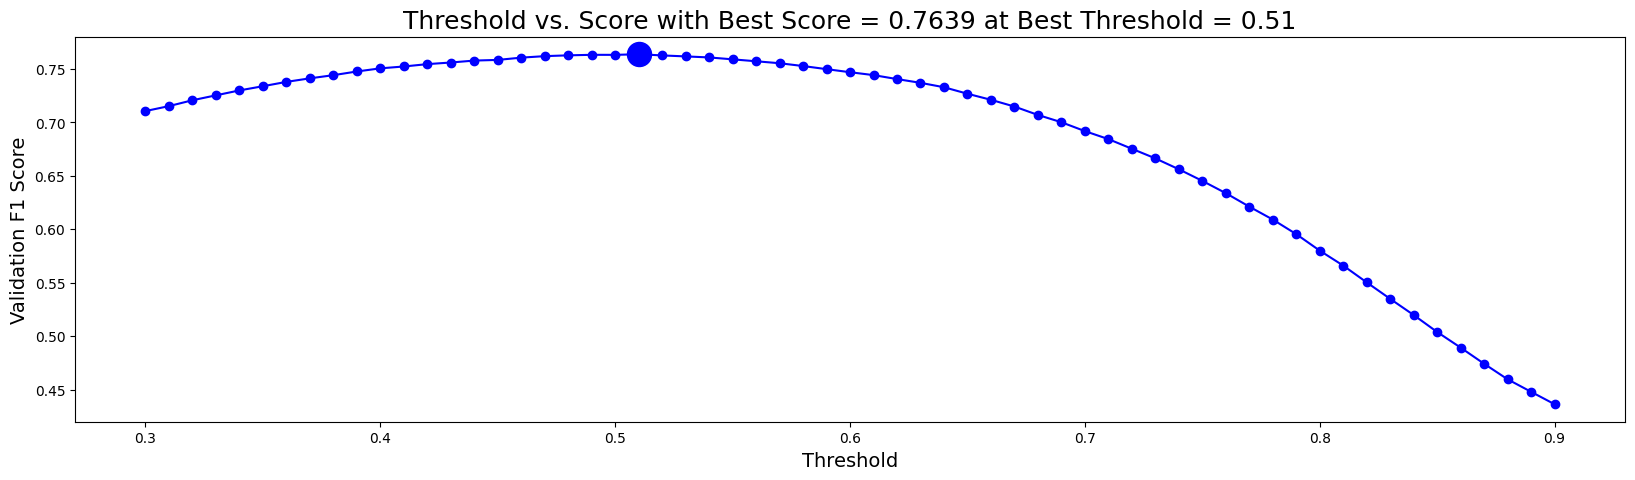

In [16]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. Score with Best Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [17]:
np.mean(scores), np.std(scores)

(0.6850571983484981, 0.09504120578173625)

In [18]:
feats = pd.DataFrame({'features': models[4].feature_name_, 'score': models[4].feature_importances_})

In [19]:
feats.sort_values('score', ascending=False, inplace=True)
feats

,features,score
1,feature2,355
4,feature5,323
12,feature13,304
6,feature7,231
2,feature3,201
3,feature4,200
11,feature12,184
14,feature15,162
13,feature14,150
5,feature6,123


In [29]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df[TARGET],
           eval_set=[(new_df[FEATURES],df[TARGET])],
           eval_metric=["logloss", "auc"],
           categorical_feature=categorical,
           verbose=50)

[50]	valid_0's binary_logloss: 0.430323	valid_0's auc: 0.865894
[100]	valid_0's binary_logloss: 0.398707	valid_0's auc: 0.88555


LGBMClassifier(colsample_bytree=0.8, max_depth=7, random_state=42,
               scale_pos_weight=1.5, subsample=0.8)

In [30]:
with open('../checkpoints/phase-1/prob-2/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

In [17]:
FEATURES

['feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature19',
 'feature20']

In [42]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.2/372.2 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.6/285.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 1.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.2

In [45]:
train_data